In [1]:
import logging
import tensorflow as tf


GPU_FROM = 0
GPU_TO = 1  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-02-27 15:33:03.108139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 15:33:03.283876: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-27 15:33:03.324290: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-27 15:33:04.001547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:

from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids

data = tf.random.stateless_binomial(shape=(10000, 100), counts=1, probs=0.8, seed=[1997,1997])+1
train_frac = int(data.shape[0]*3/4)

train_ds, val_ds = tf.data.Dataset.from_tensor_slices(data[:train_frac]), tf.data.Dataset.from_tensor_slices(data[train_frac:])

def mapper(y):
    x = tf.strings.as_string(y+3)
    x = tf.strings.reduce_join(x, axis=-1)
    return tf.strings.regex_replace(x, "(45)", r"\1 ")

train_ds = train_ds.map(mapper)
val_ds = val_ds.map(mapper)

for f in train_ds.take(5):
    print(f)

tf.Tensor(b'5555545 5555555445 5555445 545 5555545 555545 55555445 545 545 545 555545 5545 55555445 5555445 555545 55555555545 4', shape=(), dtype=string)
tf.Tensor(b'55545 5545 5545 45 555445 5445 45 5555555555545 545 555545 545 45 55545 55555545 55555545 545 45 45 445 45 55545 55555555', shape=(), dtype=string)
tf.Tensor(b'5555544445 45 55555545 45 5555445 555555545 555555555555555555545 555445 5555555545 5555545 5545 545 5445 45 45 444', shape=(), dtype=string)
tf.Tensor(b'545 555555445 555555545 555545 555555545 5555545 5555555555555445 45 45 555545 555545 5555555555555445 555555544', shape=(), dtype=string)
tf.Tensor(b'545 5555545 45 555555555445 554445 555545 555555555545 55555545 5545 555545 5555555445 55445 5555545 4445 5445 445 5', shape=(), dtype=string)


2023-02-27 15:33:05.264648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 15:33:05.978416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [3]:
def generate_labels(text):
    max_chars = 100
    last_char = tf.strings.substr(text, max_chars, max_chars+1)
    text = tf.strings.substr(text,0, max_chars)
    text = tf.strings.lower(text)
    split_on_whitespace = tf.strings.strip(tf.strings.split(text))
    encoder_in = tf.strings.reduce_join(split_on_whitespace, axis=-1)
    
    space_indices = tf.math.cumsum(tf.strings.length(split_on_whitespace)) - 1 # subtract 1 to index from 0
    seq_len = space_indices[-1] + 1
    if not tf.strings.regex_full_match(last_char, " "):
        space_indices = space_indices[:-1]
    encoder_out = tf.ones((max_chars,))
    encoder_out = tf.concat([
        tf.ones((seq_len,)),
        tf.zeros((max_chars - seq_len,))
    ], axis=-1)
    encoder_out = tf.tensor_scatter_nd_update(
        encoder_out, 
        space_indices[...,tf.newaxis], # Expand dims to create a 'list' of indices
        tf.ones_like(space_indices, dtype=encoder_out.dtype)*2) 
    
    return (encoder_in, None), tf.cast(encoder_out, "float16")

train_ds = train_ds.map(generate_labels)
val_ds = val_ds.map(generate_labels)

for f in train_ds.take(1):
    print(f)

((<tf.Tensor: shape=(), dtype=string, numpy=b'55555455555555445555544554555555455555455555544554554554555554555455555544555554455555'>, None), <tf.Tensor: shape=(100,), dtype=float16, numpy=
array([1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2.,
       1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float16)>)


In [4]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower_and_strip_punctuation",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train_ds.take(10).map(lambda x,y: x[0]))
tokenizer.get_vocabulary()

['', '[UNK]', '5', '4']

In [5]:
tokenizer("44444455555")

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [6]:
model = SpaceSegmentationTransformer(
    num_layers=2,
    d_model=32,
    num_attention_heads=2,
    seq_len=100,
    dff=32,
    input_tokenizer=tokenizer,
    num_classes = 3
)

In [7]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0), # Why can I not ignore class 0?
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [8]:
train_ds = train_ds.shuffle(100).batch(8)
val_ds = val_ds.batch(8)

model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
  7/938 [..............................] - ETA: 21s - loss: 0.6459 - sparse_categorical_accuracy: 0.7787 - space_precision: 0.1662 - space_recall: 0.0309 - space_f1: 0.0521 - char_precision: 0.7506 - char_recall: 0.9170 - char_f1: 0.8254   

2023-02-27 15:33:13.097046: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 33s 30ms/step - loss: 0.3008 - sparse_categorical_accuracy: 0.8798 - space_precision: 0.8635 - space_recall: 0.3035 - space_f1: 0.4492 - char_precision: 0.7611 - char_recall: 0.9852 - char_f1: 0.8588 - val_loss: 0.0248 - val_sparse_categorical_accuracy: 0.9977 - val_space_precision: 0.9933 - val_space_recall: 0.9910 - val_space_f1: 0.9922 - val_char_precision: 0.8421 - val_char_recall: 0.9985 - val_char_f1: 0.9136
Epoch 2/10
938/938 [==============================] - 26s 27ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9616 - space_precision: 0.8976 - space_recall: 0.8541 - space_f1: 0.8753 - char_precision: 0.8216 - char_recall: 0.9813 - char_f1: 0.8944 - val_loss: 0.0086 - val_sparse_categorical_accuracy: 0.9986 - val_space_precision: 0.9958 - val_space_recall: 0.9945 - val_space_f1: 0.9952 - val_char_precision: 0.8425 - val_char_recall: 0.9990 - val_char_f1: 0.9141
Epoch 3/10
938/938 [==============================] - 25s 27ms/step

In [9]:
model.evaluate(val_ds)

313/313 [==============================] - 4s 13ms/step - loss: 5.1292e-04 - sparse_categorical_accuracy: 0.9999 - space_precision: 0.9996 - space_recall: 0.9997 - space_f1: 0.9997 - char_precision: 0.8432 - char_recall: 0.9999 - char_f1: 0.9149


[0.0005129225319251418,
 0.9999213814735413,
 0.9995836019515991,
 0.9997345805168152,
 0.9996591210365295,
 0.8432043194770813,
 0.9999307990074158,
 0.9149041175842285]

In [10]:
test_inputs = [("5554445", "55544455554445", "5454545454545454"),(None,None, None)]
preds = model(test_inputs)
truth = tf.ragged.constant([[1,1,1,1,1,1,2], [1,1,1,1,1,1,2,1,1,1,1,1,1,2], [1,1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1]])
char_conditional = (truth == 1).to_tensor(False, shape=(truth.shape[0],100))
space_conditional = (truth == 2).to_tensor(False, shape=(truth.shape[0],100))

In [11]:
preds, tf.argmax(preds, axis=-1)

(<tf.Tensor: shape=(3, 100, 3), dtype=float32, numpy=
 array([[[5.47027071e-07, 9.99977469e-01, 2.18861460e-05],
         [4.76934929e-07, 9.99976635e-01, 2.28591380e-05],
         [2.34627620e-07, 9.99933481e-01, 6.63166502e-05],
         [1.05867036e-06, 9.99994755e-01, 4.20531478e-06],
         [1.39086353e-07, 9.99985695e-01, 1.42252093e-05],
         [4.54926663e-07, 9.99993086e-01, 6.45289083e-06],
         [1.49603466e-05, 4.84841689e-03, 9.95136678e-01],
         [3.35283943e-08, 9.98467028e-01, 1.53292215e-03],
         [2.90809030e-08, 9.98299778e-01, 1.70025777e-03],
         [2.19798402e-08, 9.98532772e-01, 1.46721269e-03],
         [2.01455297e-08, 9.98968720e-01, 1.03124557e-03],
         [2.31444925e-08, 9.99294162e-01, 7.05867948e-04],
         [2.69890243e-08, 9.99384046e-01, 6.15968078e-04],
         [3.05564534e-08, 9.99264061e-01, 7.35880923e-04],
         [3.02745491e-08, 9.99070883e-01, 9.29060916e-04],
         [2.49054981e-08, 9.98905301e-01, 1.09469937e-03],
  

Text(0.5, 0.98, 'Probabilities of space/char conditional on character input')

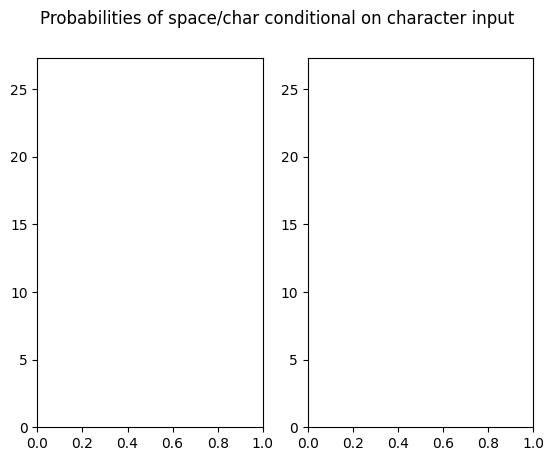

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
prob_of_space = preds[char_conditional][...,2]
prob_of_char = preds[char_conditional][...,1]
axs[0].hist(prob_of_space)
axs[0].set_xlim(0,1)
axs[1].hist(prob_of_char)
axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on character input")

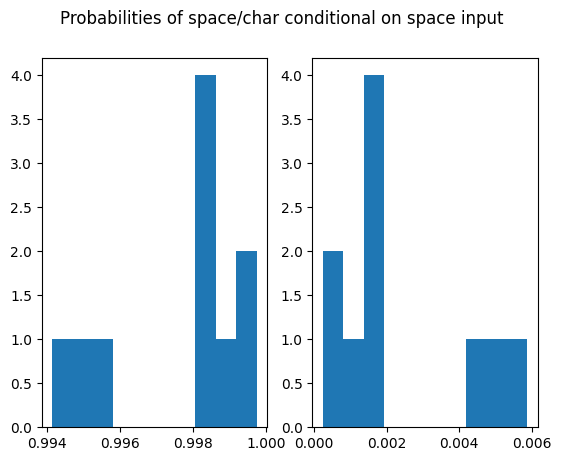

In [13]:
fig, axs = plt.subplots(1,2)
prob_of_space = preds[space_conditional][...,2]
prob_of_char = preds[space_conditional][...,1]
axs[0].hist(prob_of_space)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on space input")

fig.show()

In [14]:
list(prob_of_char.numpy()), prob_of_space

([0.004848417,
  0.00023964678,
  0.0017860088,
  0.0009837744,
  0.0014836056,
  0.0017304722,
  0.0043084803,
  0.00026708748,
  0.0015791642,
  0.0058736927],
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.9951367 , 0.99975425, 0.99820805, 0.99901605, 0.99851614,
        0.99826837, 0.9956909 , 0.99973255, 0.9984205 , 0.9941261 ],
       dtype=float32)>)

In [15]:
[len(x) for x in test_inputs[0]], preds._keras_mask.numpy().sum(axis=1)

([7, 14, 16], array([ 7, 14, 16]))